# Imports

In [99]:
import sys
import os
from google.colab import drive
from google.colab import files
from dotenv import load_dotenv
import json
import warnings
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
%matplotlib inline

# Bootstrap

In [100]:
np.random.seed(31071967)

# Find and load the .env file from the current or parent directories
load_dotenv()

drive.mount('/content/drive')

with open(f"{os.getenv('PROJECT_PATH')}/src/config.json", 'r') as f:
    project_config = json.load(f)
    project_config.pop('_comment', None)
    project_config.pop('_note', None)
    f.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [101]:
# sanity check
project_config["TKL"]

'TNYA'

# Download TKL data from YF

In [102]:
tickers_yf = {
    "y"     : f"{project_config['TKL']}",
    "NASDAQ"      : "^IXIC",
    "SP500"       : "^GSPC",
    "RealEstate"  : "VNQ",
    "Oil_WTI"     : "CL=F",
    "Gold"        : "GC=F",
    "Inflation_Exp": "^TNX"
}

In [103]:
import yfinance as yf
import pandas as pd
from pandas_datareader import data as pdr

from datetime import date, timedelta
end_date = date.today() - timedelta(days=1)
start_date = end_date - timedelta(days=int(project_config["HISTORY_DEPTH"]))

# ---- DOWNLOAD FROM YAHOO FINANCE ----
ts_yf = yf.download(
    tickers=list(tickers_yf.values()),
    start=start_date,
    end=end_date,
    auto_adjust=True
)["Close"]

# rename columns to readable names
rename_map = {v: k for k, v in tickers_yf.items()}
ts_yf = ts_yf.rename(columns=rename_map)

# Fill missing daily values for macro data (monthly)
ts_yf = ts_yf.ffill()   # forward fill
ts_yf = ts_yf.dropna()  # drop any remaining rows

ts_yf = ts_yf.reset_index().rename(columns={"Date": "Date"})

display(ts_yf.head(1))
display(ts_yf.tail(1))

[*********************100%***********************]  7 of 7 completed


Ticker,Date,Oil_WTI,Gold,y,RealEstate,SP500,NASDAQ,Inflation_Exp
0,2021-07-30,73.949997,1812.599976,15.35,90.242554,4395.259766,14672.679688,1.239


Ticker,Date,Oil_WTI,Gold,y,RealEstate,SP500,NASDAQ,Inflation_Exp
1095,2025-12-05,60.080002,4212.899902,1.41,89.879997,6870.399902,23578.130859,4.139


# Turn time series into supprvied learning table

In [104]:
df = ts_yf.copy()

lags =   [2,5,10,22,65] # lookback days
windows =  [5,10,22,65] # statistics windows

# Identify columns to generate features for (excluding 'index' column which is the date)
feature_base_cols = [c for c in df.columns if c not in ['Date','index']]

for base_col in feature_base_cols:
  for lag in lags:
    df[f"{base_col}_lag_{lag}"] = df[base_col].shift(lag)

  # Generate rolling window statistics for the current base_col
  for window in windows:
    df[f"{base_col}_min_{window}"] = df[base_col].rolling(window=window).min()
    df[f"{base_col}_max_{window}"] = df[base_col].rolling(window=window).max()
    df[f"{base_col}_mean_{window}"] = df[base_col].rolling(window=window).mean()
    df[f"{base_col}_std_{window}"]  = df[base_col].rolling(window=window).std()
    df[f"{base_col}_diff_{window}"] = df[base_col].diff(window)
    df[f"{base_col}_pct_{window}"] = df[base_col].pct_change(window)


df['y_next'] = df['y'].shift(-1)    # tomorrow's close price
df.tail(1)['y_next'] = -1           # the TARGET cell

df.dropna(inplace=True)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

cols_to_scale = df.drop(['Date', 'y_next'], axis=1).columns

for col in cols_to_scale:
  df[f"{col}_orig"] = df[col]

df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

df.tail(1)

Ticker,Date,Oil_WTI,Gold,y,RealEstate,SP500,NASDAQ,Inflation_Exp,Oil_WTI_lag_2,Oil_WTI_lag_5,...,Inflation_Exp_mean_22_orig,Inflation_Exp_std_22_orig,Inflation_Exp_diff_22_orig,Inflation_Exp_pct_22_orig,Inflation_Exp_min_65_orig,Inflation_Exp_max_65_orig,Inflation_Exp_mean_65_orig,Inflation_Exp_std_65_orig,Inflation_Exp_diff_65_orig,Inflation_Exp_pct_65_orig
1094,2025-12-04,0.038155,0.954075,0.033982,0.708427,0.989809,0.967019,0.758573,0.022683,0.022833,...,4.0885,0.044566,0.002,0.000487,3.953,4.187,4.078923,0.058712,-0.103,-0.02446


# Split

In [105]:
tommorw_date = df.tail(1)['Date'] # Changed 'Date' to 'index'

X = df[cols_to_scale]
y = df['y_next']

X_train, X_test = X.iloc[:-2], X.iloc[-1:]
y_train, y_test = y.iloc[:-2], y.iloc[-1:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1028, 210), (1, 210), (1028,), (1,))

# Train, Predict, Evaluate

In [106]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

xgb = XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror")

xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

In [107]:
pred = xgb.predict(X_test)
mae = mean_absolute_error(y_test, pred)
print("MAE:", mae)

MAE: 0.07389950752258301


In [108]:
last_row = X_test # Use X_test which was successfully predicted upon
tomorrow_prediction = xgb.predict(last_row)[0]
#tomorrow_prediction_original_value = scaler.inverse_transform(tomorrow_prediction)
print(f"Stoke: {project_config['TKL']}")
print(f"Date: {tommorw_date.iloc[0].date()}")
print(f"Close Prediction: ${tomorrow_prediction:.2f}")

Stoke: TNYA
Date: 2025-12-04
Close Prediction: $1.34


# Feature selection

<Figure size 1000x600 with 0 Axes>

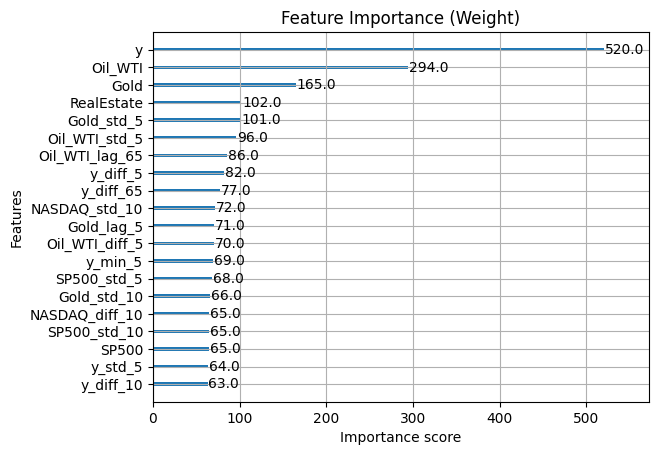

['y', 'Oil_WTI', 'Gold', 'RealEstate', 'Gold_std_5', 'Oil_WTI_std_5', 'Oil_WTI_lag_65', 'y_diff_5', 'y_diff_65', 'NASDAQ_std_10', 'Gold_lag_5', 'Oil_WTI_diff_5']


In [109]:
import matplotlib.pyplot as plt
import xgboost # Import the xgboost module

# Plot feature importance based on "weight" (number of times a feature appears in a tree)
plt.figure(figsize=(10, 6))
xgboost.plot_importance(xgb, max_num_features=20) # Pass the xgb regressor object
plt.title("Feature Importance (Weight)")
plt.show()

# Get the feature importance dictionary
# importance_type can be 'weight', 'gain', or 'cover'
importance_dict = xgb.get_booster().get_score(importance_type='weight')

# 2. Convert to a Pandas DataFrame for easy sorting and viewing
df_importance = pd.DataFrame(list(importance_dict.items()), columns=['Feature', 'Score'])

# 3. Sort by Score (High to Low)
df_importance = df_importance.sort_values(by='Score', ascending=False)

# 4. Extract just the names into a Python list (for use in code)
top_weight_features_list = df_importance['Feature'].head(12).tolist()
print(top_weight_features_list)

<Figure size 1000x600 with 0 Axes>

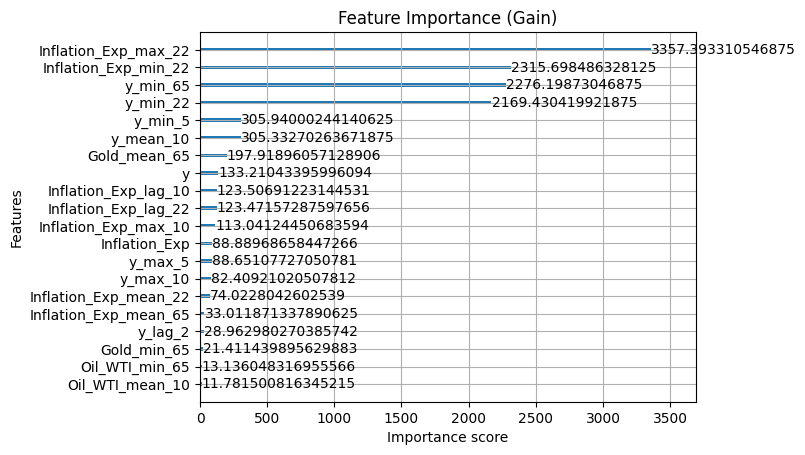

['Inflation_Exp_max_22', 'Inflation_Exp_min_22', 'y_min_65', 'y_min_22', 'y_min_5', 'y_mean_10', 'Gold_mean_65', 'y', 'Inflation_Exp_lag_10', 'Inflation_Exp_lag_22', 'Inflation_Exp_max_10', 'Inflation_Exp']


In [110]:
# OPTIONAL: Plot based on "gain" (average gain of splits which use the feature)
# "Gain" is often more accurate for finding what actually drives the prediction.
plt.figure(figsize=(10, 6))
xgboost.plot_importance(xgb, importance_type='gain', max_num_features=20) # Pass the xgb regressor object
plt.title("Feature Importance (Gain)")
plt.show()

# Get the feature importance dictionary
# importance_type can be 'weight', 'gain', or 'cover'
importance_dict = xgb.get_booster().get_score(importance_type='gain')

# 2. Convert to a Pandas DataFrame for easy sorting and viewing
df_importance = pd.DataFrame(list(importance_dict.items()), columns=['Feature', 'Score'])

# 3. Sort by Score (High to Low)
df_importance = df_importance.sort_values(by='Score', ascending=False)

# 4. Extract just the names into a Python list (for use in code)
top_gain_features_list = df_importance['Feature'].head(12).tolist()
print(top_gain_features_list)

In [111]:
top_features = list(set(top_gain_features_list) | set(top_weight_features_list))
top_features

['Oil_WTI_lag_65',
 'Gold_lag_5',
 'NASDAQ_std_10',
 'Gold_mean_65',
 'Inflation_Exp_min_22',
 'Oil_WTI',
 'Oil_WTI_std_5',
 'Inflation_Exp_max_22',
 'y_diff_5',
 'Inflation_Exp_lag_22',
 'Oil_WTI_diff_5',
 'Inflation_Exp_lag_10',
 'Gold',
 'Inflation_Exp',
 'y_min_22',
 'Inflation_Exp_max_10',
 'y_diff_65',
 'y',
 'RealEstate',
 'y_mean_10',
 'Gold_std_5',
 'y_min_65',
 'y_min_5']

# Final df

In [112]:
final_df = df[['Date','y_next'] + top_features]

for col in top_features:
    final_df[f"{col}_orig"] = df[f"{col}_orig"]

display(final_df.tail(1))
final_df.info()

Ticker,Date,y_next,Oil_WTI_lag_65,Gold_lag_5,NASDAQ_std_10,Gold_mean_65,Inflation_Exp_min_22,Oil_WTI,Oil_WTI_std_5,Inflation_Exp_max_22,...,Inflation_Exp_orig,y_min_22_orig,Inflation_Exp_max_10_orig,y_diff_65_orig,y_orig,RealEstate_orig,y_mean_10_orig,Gold_std_5_orig,y_min_65_orig,y_min_5_orig
1094,2025-12-04,1.41,0.102749,0.936899,0.479782,1.0,0.816421,0.038155,0.029114,0.759688,...,4.108,1.16,4.108,0.2,1.38,89.980003,1.281,19.918821,1.16,1.22


<class 'pandas.core.frame.DataFrame'>
Index: 1030 entries, 65 to 1094
Data columns (total 48 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       1030 non-null   datetime64[ns]
 1   y_next                     1030 non-null   float64       
 2   Oil_WTI_lag_65             1030 non-null   float64       
 3   Gold_lag_5                 1030 non-null   float64       
 4   NASDAQ_std_10              1030 non-null   float64       
 5   Gold_mean_65               1030 non-null   float64       
 6   Inflation_Exp_min_22       1030 non-null   float64       
 7   Oil_WTI                    1030 non-null   float64       
 8   Oil_WTI_std_5              1030 non-null   float64       
 9   Inflation_Exp_max_22       1030 non-null   float64       
 10  y_diff_5                   1030 non-null   float64       
 11  Inflation_Exp_lag_22       1030 non-null   float64       
 12  Oil_WTI_di

# CSV

In [113]:
df_csv_path = f"{os.getenv('PROJECT_PATH')}{project_config['data_directory']}{project_config['TKL']}.df.csv"
final_df.to_csv(df_csv_path)